In [1]:
from IPython import display
import random
import numpy as np
import torch
import pickle
import timeit
import time
import argparse
import pprint
from pathlib import Path
from confs import fln, fln2, Logistic
from tqdm import tqdm_notebook as tqdm
import numpy.random as npr
from utilsNew import *

In [2]:
import matplotlib.pyplot as plt
import pickle

In [3]:
cudaid = 0
torch.cuda.set_device(cudaid)
torch.manual_seed(0) # cpu
torch.cuda.manual_seed(0) #gpu
np.random.seed(0) #numpy
random.seed(0) #random and transforms
torch.backends.cudnn.deterministic=True # cudnn

In [4]:
torch.set_default_dtype(torch.float64)
cuda = torch.cuda.is_available()
if cuda:
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)

In [5]:
def emfRun(R, CT, Cb, etaT, etab, maxIter=100, is_plot=False, is_showPro=False):
    LamT = LamTfn(CT, n, m, p)
    Lamb = Lambfn(Cb, n, m)
    betaOld, bThetaOld = betainit, bThetainit
    
    
    Ynew = Y.clone()
    Rb = (1-R.to_dense()).to_sparse()
    
    reCh = 10
    Losses = []
    betaDiffs = []
    bThetaDiffs = []
    betaErrs = []
    bThetaErrs = []
    betaL0s = []
    bThetaRanks = []
    
    if is_showPro:
        IterShowBar = tqdm(range(maxIter))
    else:
        IterShowBar = range(maxIter)
    for t in IterShowBar:
        # estimate Y at current parameters
        Yhat = X.to_dense().matmul(betaOld) + bThetaOld
        probs = Logistic(Yhat)
        # impute the missing terms with estimated value
        Ynew[Rb.to_dense().bool()] = probs[Rb.to_dense().bool()] 
        
        t0 = time.time()
        LvNow = emLossL(bThetaOld, betaOld, f, X, Ynew, is_logf=False)
        t1 = time.time()
       
        # update beta
        LpbvOld = emLossLpb(bThetaOld, betaOld, conDenfs[:3], X, Ynew)
        betaNewRaw = betaOld - etab * LpbvOld
        betaNew = SoftTO(betaNewRaw, etab*Lamb)
       
        t2 = time.time()
        LpTvOld = emLossLpT(bThetaOld, betaNew, conDenfs[:3], X, Ynew)
        t3 = time.time()
        svdres = torch.svd_lowrank(bThetaOld-LpTvOld*etaT, q=10) # it can be very  fast
        U, S, V =  svdres
        softS = (S-LamT*etaT).clamp_min(0)
        bThetaNew = U.matmul(torch.diag(softS)).matmul(V.t())
        
        LossNow = LossWP(LvNow, softS, betaNew, LamT, Lamb)
        Losses.append(LossNow.item())
        t4 = time.time()
        
        ts = np.array([t0, t1, t2, t3, t4])
        #print(np.diff(ts), torch.matrix_rank(bThetaOld))
    
        if t >= 1:
            Lk1 = Losses[-1]
            Lk = Losses[-2]
            reCh = np.abs(Lk1-Lk)/np.max(np.abs((Lk, Lk1, 1))) 
        betaDiff = (betaOld-betaNew).norm().item()/(betaNew.norm().item()+1e-6)
        bThetaDiff = (bThetaOld-bThetaNew).norm().item()/(bThetaNew.norm().item()+1e-6)
        betaDiffs.append(betaDiff)
        bThetaDiffs.append(bThetaDiff)
        betaL0s.append(len(torch.nonzero(betaNew)))
        bThetaRanks.append(torch.linalg.matrix_rank(bThetaNew).item())
        
        betaOld, bThetaOld = betaNew, bThetaNew 
        etaT = etaT * 0.96
        etab = etab * 0.95
        
        
        # plot res
        if t >= 1 and is_plot:
            plt.figure(figsize=[15, 5])
            
            plt.subplot(131)
            plt.xlim([0, maxIter])
            #plt.ylim([-10, 5])
            plt.title("Loss Diff")
            lossDifs = np.log(np.abs(np.diff(Losses)))
            plt.plot(list(range(0, t)), lossDifs)
            plt.scatter(t-1, lossDifs[-1], color="red", s=20)
            plt.axhline(y=np.log(tol), color="green", linewidth=2, linestyle='--')
            
            plt.subplot(132)
            plt.xlim([0, maxIter])
            #plt.ylim([0, p])
            plt.title("Beta L0")
            plt.plot(list(range(0, t+1)), betaL0s)
            plt.scatter(t, betaL0s[-1], color="red", s=20)
            plt.text(t, betaL0s[-1], f"L0 norm is {betaL0s[-1]:.0f}")
            plt.axhline(y=5, color="green", linewidth=2, linestyle='--')
            
            plt.subplot(133)
            plt.xlim([0, maxIter])
            #plt.ylim([0, np.min([n, m])])
            plt.title("Theta Rank")
            plt.plot(list(range(0, t+1)), bThetaRanks)
            plt.scatter(t, bThetaRanks[-1], color="red", s=20)
            plt.text(t, bThetaRanks[-1], f"rank is {bThetaRanks[-1]:.0f}")
            plt.axhline(y=5, color="green", linewidth=2, linestyle='--')
            
            #if (reCh >= tol) and ((bThetaDiff >= tolT) or (betaDiff >= tolb)) and (t<=(maxIter-1)):
            display.clear_output(wait=True)
            plt.pause(1e-7)
            
        if (reCh < tol):
            break
        
        if (bThetaDiff < tolT) and (betaDiff < tolb):
            break
    
    res = {}
    res["beta"] = betaNew.cpu().numpy()
    res["bTheta"] = bThetaNew.cpu().numpy()
    res["IterNum"] = t
    res["betaDiffs"] = betaDiffs
    res["bThetaDiffs"] = bThetaDiffs
    res["loss"] = Losses
    res["betaNorm0"] = len(torch.nonzero(betaNew))
    res["bThetaRank"] = torch.linalg.matrix_rank(bThetaNew).item()
    return res

In [104]:
def marfRun(R, etaT, etab, maxIter=100, nR=16, is_plot=False, is_showPro=False):
    #LamT = LamTfn(CT, n, m, p)
    #Lamb = Lambfn(Cb, n, m)
    Lamb = 0
    LamT = 0
    betaOld, bThetaOld = betainit, bThetainit
    
    
    reCh = 10
    Losses = []
    betaDiffs = []
    bThetaDiffs = []
    betaNorms = []
    bThetaNorms = []
    betaL0s = []
    bThetaRanks = []
    
    if is_showPro:
        IterShowBar = tqdm(range(maxIter))
    else:
        IterShowBar = range(maxIter)
    for t in IterShowBar:
        t0 = time.time()
        #LvNow = marLinearLossL(X, Y, R, bThetaOld, betaOld, sigma=sigmaY) 
        LvNow = marLossL(bThetaOld, betaOld, f, X, Y, R, is_logf=False)
        t1 = time.time()
       
        # update beta
        LpbvOld = marLossLpb(bThetaOld, betaOld, conDenfs[:3], X, Y, R)
        betaNewRaw = betaOld - etab * LpbvOld
        betaNew = betaNewRaw
        #betaNew = SoftTO(betaNewRaw, etab*Lamb)
       
        t2 = time.time()
        LpTvOld = marLossLpT(bThetaOld, betaNew, conDenfs[:3], X, Y, R)
        t3 = time.time()
        svdres = torch.svd_lowrank(bThetaOld-LpTvOld*etaT, q=20) # it can be very  fast
        #svdres = torch.svd(bThetaOld-LpTvOld*etaT)
        U, S, V =  svdres
        bThetaNew = U[:, :nR].matmul(torch.diag(S[:nR])).matmul(V[:, :nR].t())
        #softS = (S-LamT*etaT).clamp_min(0)
        #bThetaNew = U.matmul(torch.diag(softS)).matmul(V.t())
        
        LossNow = LossWP(LvNow, S[:nR], betaNew, LamT, Lamb)
        #LossNow = LossWP(LvNow, softS, betaNew, LamT, Lamb)
        Losses.append(LossNow.item())
        t4 = time.time()
        
        ts = np.array([t0, t1, t2, t3, t4])
        #print(np.diff(ts), torch.matrix_rank(bThetaOld))
    
        if t >= 1:
            Lk1 = Losses[-1]
            Lk = Losses[-2]
            reCh = np.abs(Lk1-Lk)/np.max(np.abs((Lk, Lk1, 1))) 
        betaDiff = (betaOld-betaNew).norm().item()/(betaNew.norm().item()+1e-6)
        bThetaDiff = (bThetaOld-bThetaNew).norm().item()/(bThetaNew.norm().item()+1e-6)
        bThetaNorms.append(bThetaNew.norm().item())
        betaNorms.append(betaNew.norm().item())
        betaDiffs.append(betaDiff)
        bThetaDiffs.append(bThetaDiff)
        betaL0s.append(len(torch.nonzero(betaNew)))
        bThetaRanks.append(torch.linalg.matrix_rank(bThetaNew).item())
        
        betaOld, bThetaOld = betaNew, bThetaNew 
        etaT = etaT * 0.96
        etab = etab * 0.95
        
        
        # plot res
        if t >= 1 and is_plot:
            plt.figure(figsize=[15, 5])
            
            plt.subplot(131)
            plt.xlim([0, maxIter])
            #plt.ylim([-10, 5])
            plt.title("Loss Diff")
            lossDifs = np.log(np.abs(np.diff(Losses)))
            plt.plot(list(range(0, t)), lossDifs)
            plt.scatter(t-1, lossDifs[-1], color="red", s=20)
            plt.axhline(y=np.log(tol), color="green", linewidth=2, linestyle='--')
            
            
            plt.subplot(132)
            plt.xlim([0, maxIter])
            #plt.ylim([0, p])
            plt.title("Theta Norm")
            plt.plot(list(range(0, t+1)), bThetaNorms)
            plt.scatter(t, bThetaNorms[-1], color="red", s=20)
            plt.text(t, bThetaNorms[-1], f"Theta norm is {bThetaNorms[-1]:.3f}")
            #plt.axhline(y=5, color="green", linewidth=2, linestyle='--')
            
            plt.subplot(133)
            plt.xlim([0, maxIter])
            #plt.ylim([0, np.min([n, m])])
            plt.title("beta norm")
            plt.plot(list(range(0, t+1)), betaNorms)
            plt.scatter(t, betaNorms[-1], color="red", s=20)
            plt.text(t, betaNorms[-1], f"Beta norm is {betaNorms[-1]:.3f}")
            #plt.axhline(y=5, color="green", linewidth=2, linestyle='--')
            
            #if (reCh >= tol) and ((bThetaDiff >= tolT) or (betaDiff >= tolb)) and (t<=(maxIter-1)):
            display.clear_output(wait=True)
            plt.pause(1e-7)
            
        if (reCh < tol):
            break
        
        if (bThetaDiff < tolT) and (betaDiff < tolb):
            break
    
    res = {}
    res["beta"] = betaNew.cpu().numpy()
    res["bTheta"] = bThetaNew.cpu().numpy()
    res["IterNum"] = t
    res["betaDiffs"] = betaDiffs
    res["bThetaDiffs"] = bThetaDiffs
    res["loss"] = Losses
    res["betaNorm0"] = len(torch.nonzero(betaNew))
    res["bThetaRank"] = torch.linalg.matrix_rank(bThetaNew).item()
    return res

In [72]:
def fRun(R, etaT, etab, maxIter=100, nR=16, is_plot=False, is_showPro=False):
    #LamT = LamTfn(CT, n, m, p)
    LamT = 0
    Lamb = 0
    betaOld, bThetaOld = betainit, bThetainit
    
    
    reCh = 10
    Losses = []
    betaDiffs = []
    bThetaDiffs = []
    betaErrs = []
    bThetaErrs = []
    betaL0s = []
    bThetaRanks = []
    
    if is_showPro:
        IterShowBar = tqdm(range(maxIter))
    else:
        IterShowBar = range(maxIter)
    for t in IterShowBar:
        t0 = time.time()
        LvNow = lossLBern(bThetaOld, betaOld, f, X, Y, R, probs=probs, fct=fct, is_logf=False)
        
        t1 = time.time()
        # update beta
        LpbvOld = lossLpbBern(bThetaOld, betaOld, conDenfs[:3], X, Y, R, probs=probs, fct=fct)
        betaNewRaw = betaOld - etab * LpbvOld
        betaNew = betaNewRaw
        #betaNew = SoftTO(betaNewRaw, etab*Lamb)
       
        t2 = time.time()
        LpTvOld = lossLpTBern(bThetaOld, betaNew, conDenfs[:3], X, Y, R, probs=probs, fct=fct)
       
        t3 = time.time()
        # update Theta
        #svdres = torch.svd(bThetaOld-LpTvOld*etaT)
        svdres = torch.svd_lowrank(bThetaOld-LpTvOld*etaT, q=20) # it can be very  fast
        U, S, V =  svdres
        bThetaNew = U[:, :nR].matmul(torch.diag(S[:nR])).matmul(V[:, :nR].t())
        #softS = (S-LamT*etaT).clamp_min(0)
        #bThetaNew = U.matmul(torch.diag(softS)).matmul(V.t())
        
        LossNow = LossWP(LvNow, S, betaNew, LamT, Lamb)
        Losses.append(LossNow.item())
        t4 = time.time()
        
        ts = np.array([t0, t1, t2, t3, t4])
        #print(np.diff(ts), torch.matrix_rank(bThetaOld))
    
        if t >= 1:
            Lk1 = Losses[-1]
            Lk = Losses[-2]
            reCh = np.abs(Lk1-Lk)/np.max(np.abs((Lk, Lk1, 1))) 
        betaDiff = (betaOld-betaNew).norm().item()/(betaNew.norm().item()+1e-6)
        bThetaDiff = (bThetaOld-bThetaNew).norm().item()/(bThetaNew.norm().item()+1e-6)
        betaDiffs.append(betaDiff)
        bThetaDiffs.append(bThetaDiff)
        betaL0s.append(len(torch.nonzero(betaNew)))
        bThetaRanks.append(torch.linalg.matrix_rank(bThetaNew).item())
        
        betaOld, bThetaOld = betaNew, bThetaNew 
        etaT = etaT * 0.96
        etab = etab * 0.95
        
        
        # plot res
        if t >= 1 and is_plot:
            plt.figure(figsize=[15, 5])
            
            plt.subplot(131)
            plt.xlim([0, maxIter])
            #plt.ylim([-10, 5])
            plt.title("Loss Diff")
            lossDifs = np.log(np.abs(np.diff(Losses)))
            plt.plot(list(range(0, t)), lossDifs)
            plt.scatter(t-1, lossDifs[-1], color="red", s=20)
            plt.axhline(y=np.log(tol), color="green", linewidth=2, linestyle='--')
            
            
            plt.subplot(132)
            plt.xlim([0, maxIter])
            #plt.ylim([0, p])
            plt.title("Beta L0")
            plt.plot(list(range(0, t+1)), betaL0s)
            plt.scatter(t, betaL0s[-1], color="red", s=20)
            plt.text(t, betaL0s[-1], f"L0 norm is {betaL0s[-1]:.0f}")
            plt.axhline(y=5, color="green", linewidth=2, linestyle='--')
            
            plt.subplot(133)
            plt.xlim([0, maxIter])
            #plt.ylim([0, np.min([n, m])])
            plt.title("Theta Rank")
            plt.plot(list(range(0, t+1)), bThetaRanks)
            plt.scatter(t, bThetaRanks[-1], color="red", s=20)
            plt.text(t, bThetaRanks[-1], f"rank is {bThetaRanks[-1]:.0f}")
            
            #if (reCh >= tol) and ((bThetaDiff >= tolT) or (betaDiff >= tolb)) and (t<=(maxIter-1)):
            display.clear_output(wait=True)
            plt.pause(1e-7)
            
        if (reCh < tol):
            break
        if (bThetaDiff < tolT) and (betaDiff < tolb):
            break
    
    res = {}
    res["beta"] = betaNew.cpu().numpy()
    res["bTheta"] = bThetaNew.cpu().numpy()
    res["IterNum"] = t
    res["betaDiffs"] = betaDiffs
    res["bThetaDiffs"] = bThetaDiffs
    res["loss"] = Losses
    res["betaNorm0"] = len(torch.nonzero(betaNew))
    res["bThetaRank"] = torch.linalg.matrix_rank(bThetaNew).item()
    return res

In [8]:
def GenMissing(Yraw, OR=0.03, y1ratio=0.5):
    """
    OR: observed ratio.
    y1ratio: num of 1 / (num of 1 and 0) in the removed part
    """
    # get the R
    R = Yraw.clone()
    R[Yraw!=0] = 1

    rawOR = R.sum()/R.numel()
    assert OR <= rawOR
    
    numrv = R.numel() * (rawOR-OR) # number of samples to remove
    numrv1 = int(numrv*y1ratio) # number of 1 to remove
    numrv0 = int(numrv) - numrv1 # number of 0 to remove

    mask1 = (Yraw > 3.5) & (R==1) # matrix with observed 1 as True
    mask0 = (Yraw < 3.5) & (R==1) # matrix with observed 0 as True
    selidx1 = np.random.choice(int(torch.sum(mask1)), numrv1, replace=0)
    selidx0 = np.random.choice(int(torch.sum(mask0)), numrv0, replace=0)

    tmp1 = R[mask1] 
    tmp1[selidx1] = 0
    R[mask1] = tmp1

    tmp0 = R[mask0] 
    tmp0[selidx0] = 0
    R[mask0] = tmp0

    return R.double().to_sparse()


In [9]:
def argQsFn(vec):
    return vec.argsort(descending=True).argsort()/vec.numel()

In [10]:
def RankMetric(res, R, Rtrain):
    eProbs = Logistic(X.to_dense().matmul(torch.tensor(res["beta"])) + torch.tensor(res["bTheta"]))
    Rdiff = R.to_dense() - Rtrain.to_dense()
    eProbsQ = torch.zeros_like(eProbs)
    for i in range(eProbs.shape[0]):
        eProbsQ[i, :] = argQsFn(eProbs[i, :])
    testProbsQ = eProbsQ[Rdiff==1]
    testYraw = Yraw.to_dense()[Rdiff==1]
    metric = torch.sum(testProbsQ * testYraw)/torch.sum(testYraw)
    return metric

In [11]:
def RankMetricALS(res, R, Rtrain):
    eProbs = torch.tensor(np.matmul(res.item_factors, res.user_factors.T))
    Rdiff = R.to_dense() - Rtrain.to_dense()
    eProbsQ = torch.zeros_like(eProbs)
    for i in range(eProbs.shape[0]):
        eProbsQ[i, :] = argQsFn(eProbs[i, :])
    testProbsQ = eProbsQ[Rdiff==1]
    testYraw = Yraw.to_dense()[Rdiff==1]
    metric = torch.sum(testProbsQ * testYraw)/torch.sum(testYraw)
    return metric

### Load the data

In [12]:
datDir = Path("./MovieLens/")

In [13]:
with open(datDir/"mvlensX.pkl", "rb") as f:
    X = pickle.load(f)
with open(datDir/"mvlensY.pkl", "rb") as f:
    Yraw = pickle.load(f)
with open(datDir/"mvlensR.pkl", "rb") as f:
    R = pickle.load(f)

In [14]:
Yb = Yraw.clone().to_dense()
Yb[Yraw.to_dense()>=4] = 1
Yb[Yraw.to_dense()<=3] = 0

In [15]:
R = R.cuda().double()
Y = Yb.cuda().double()
X = X.cuda().double()
Yraw = Yraw.cuda()

### My Method

In [16]:
conDenfs = [fln, fln2, fln2]
f = fln

In [28]:
tol = 1e-8
tolT = 0
tolb = 0

In [106]:
n, m = R.shape
p = 2
betainit = torch.tensor([0, 0.0])
bThetainit = torch.randn((n, m))*0.0

In [103]:
# missing matrix after removing some entries.
Rtrain = GenMissing(Yraw.to_dense(), 0.03)
Rtrain =  Rtrain.cuda()

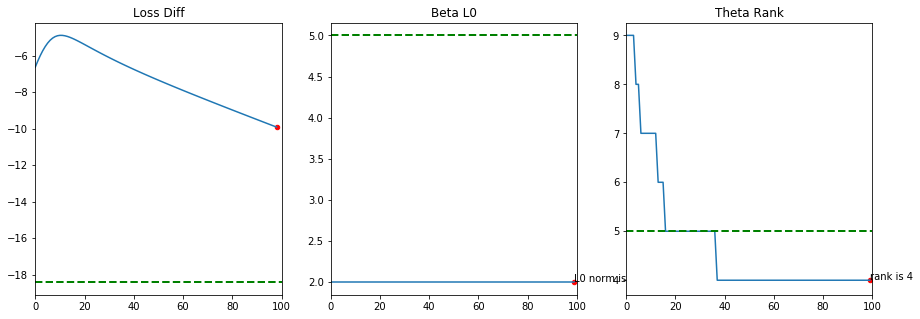

In [72]:
paraX = [1e-4, 1e1, 2]
resEM = emfRun(Rtrain, CT=paraX[0], Cb=0, etaT=paraX[1], etab=paraX[2], maxIter=100, is_plot=1, is_showPro=1)

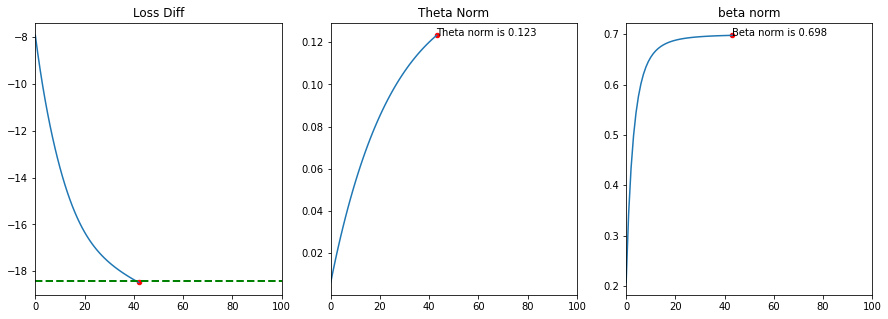

In [107]:
paraX = [1e3, 1e2]
resMAR = marfRun(Rtrain, etaT=paraX[0], etab=paraX[1], maxIter=100, is_plot=1, is_showPro=1)

In [108]:
print(RankMetric(resMAR, R, Rtrain))

tensor(0.4471)


In [97]:
resMAR["beta"]

array([0.25404539, 0.65422673])

In [34]:
print(RankMetric(resMNAR, R, Rtrain))

tensor(0.4412)


In [98]:
etaTs = [1e3, 1e4, 1e5, 1e6]
etabs = [1e1, 1e2, 1e3]
bThetainit = torch.tensor(resMAR["bTheta"])
betainit = torch.tensor(resMAR["beta"])
probs = X.to_dense().mean(axis=[0, 1])
MNARtress = []
fct = 1
for etab in etabs:
    for etaT in etaTs:
        resMNAR = fRun(Rtrain, etaT=etaT, etab=etab, maxIter=100, is_plot=0, is_showPro=1)
        MNARtress.append((etab, etaT, RankMetric(resMNAR, R, Rtrain), resMNAR))


/home/huaqingj/MyResearch/MNAR/utilsNew.py:233: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  probs = torch.tensor(probs)
/home/huaqingj/MyResearch/MNAR/utilsNew.py:258: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  probs = torch.tensor(probs)


In [99]:
[i[2] for i in MNARtress]

[tensor(0.4476),
 tensor(0.4473),
 tensor(0.4458),
 tensor(0.4573),
 tensor(0.4476),
 tensor(0.4474),
 tensor(0.4458),
 tensor(0.4570),
 tensor(0.4476),
 tensor(0.4476),
 tensor(0.4459),
 tensor(0.4584)]

In [102]:
MNARtress[-1][-1]["bTheta"] - MNARtress[-3][-1]["bTheta"]

array([[ 1.29085934e-02,  3.40385867e-03,  1.38713055e-03, ...,
         2.08615299e-05, -2.96783129e-04, -1.19016968e-03],
       [ 1.44349297e-02,  3.71669162e-03, -1.31132573e-03, ...,
        -2.15924902e-04, -8.42323661e-04, -4.95041092e-03],
       [ 1.54463668e-02,  2.39634996e-03,  1.49270873e-03, ...,
         7.04608117e-04,  3.69897824e-04,  2.25394073e-04],
       ...,
       [ 5.12007564e-03, -6.96315288e-04, -4.99481472e-05, ...,
         2.01919047e-04, -1.71464233e-05, -2.61973371e-04],
       [ 4.87524800e-03,  1.83165296e-03,  1.33044820e-03, ...,
        -7.54704868e-04, -3.85530483e-04, -7.32653558e-04],
       [ 1.84893618e-02,  5.38727292e-04, -1.30227011e-03, ...,
        -1.53513472e-03, -1.28373445e-03, -9.22892300e-03]])

In [101]:
MNARtress[0][-1]["bTheta"]

array([[ 2.01495355e-02,  1.58574799e-03,  1.22696135e-03, ...,
         6.19538071e-04, -8.36251575e-05, -6.97639741e-04],
       [ 1.25959715e-03, -2.01440211e-03,  8.52992093e-04, ...,
         1.77352821e-05, -3.70064609e-06,  3.14222107e-03],
       [-4.25688616e-04,  2.01265444e-03,  6.31481560e-04, ...,
         4.39245460e-04, -1.48390893e-06, -4.79314113e-04],
       ...,
       [-2.08585899e-03,  8.00696882e-04,  4.85344403e-05, ...,
        -1.14479643e-05,  6.21893078e-05,  4.50802470e-04],
       [ 5.54805516e-03, -7.01309508e-04, -4.61047725e-04, ...,
        -3.86329199e-04, -1.94613394e-05,  6.12315895e-04],
       [ 1.16540224e-02, -2.36470264e-03, -2.14447451e-03, ...,
        -4.63654239e-04,  3.28830027e-04,  8.15861422e-04]])

In [78]:
print(
RankMetric(resEM, R, Rtrain),
RankMetric(resMAR, R, Rtrain),
RankMetric(resMNAR, R, Rtrain)
)

tensor(0.4348) tensor(0.4227) tensor(0.4210)


### Method of ALS

In [134]:
numFcts = [1, 2, 4, 8, 16, 32, 64, 128, 256]

In [135]:
resALS = ddict(list)
for numFct in tqdm(numFcts):
    for i in tqdm(range(10)):
        # remove some data
        Rtrain = GenMissing(Yraw.to_dense(), 0.03)
        Rtrain =  Rtrain.cuda()
        Yn = Yraw.clone().to_dense()
        Yn[Rtrain.to_dense()==0] = 0
        
        # obtain data for training
        YtrainArr = csr_matrix(Yn.cpu().numpy())
        YtrainArr.data[YtrainArr.data < 4] = 0
        YtrainArr.eliminate_zeros()
        YtrainArr.data = np.ones(len(YtrainArr.data))
        
        ALSmodel = AlternatingLeastSquares(numFct)
        ALSmodel.fit(YtrainArr)
        
        res = RankMetricALS(ALSmodel, R, Rtrain)
        resALS[numFct].append(res)

In [145]:
ressMean = []
for numFct in numFcts:
    resMean = torch.tensor(resALS[numFct]).mean()
    ressMean.append(resMean.item())

In [156]:
optNumFct = numFcts[np.argmin(ressMean)]
minErr = ressMean[np.argmin(ressMean)]

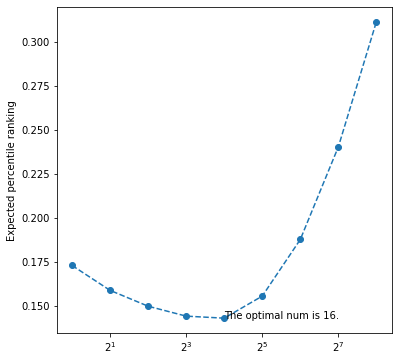

In [160]:
plt.figure(figsize=[6, 6])
plt.plot(numFcts, ressMean, "o--")
plt.text(optNumFct, minErr, f"The optimal num is {optNumFct}.")
plt.ylabel("Expected percentile ranking")
plt.xscale("log", basex=2)

In [179]:
print(f"The optimal num of factors is {optNumFct},"
      f"The expected percentile ranking is {minErr:.3f}."
     )

The optimal num of factors is 16,The expected percentile ranking is 0.143.
